In [1350]:
pip install --upgrade mxnet~=1.7 gluonts

In [1351]:
# Third-party imports
%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

In [1352]:
# gluon datasets
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas

In [1353]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'exchange_rate_nips', 'electricity_nips', 'traffic_nips', 'solar_nips', 'wiki-rolling_nips', 'taxi_30min', 'kaggle_web_traffic_with_missing', 'kaggle_web_traffic_without_missing', 'kaggle_web_traffic_weekly', 'm1_yearly', 'm1_quarterly', 'm1_monthly', 'nn5_daily_with_missing', 'nn5_daily_without_missing', 'nn5_weekly', 'tourism_monthly', 'tourism_quarterly', 'tourism_yearly', 'm3_monthly', 'm3_quarterly', 'm3_yearly', 'm3_other', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly', 'm5']


In [1354]:
pip install mxnet

In [1355]:
dataset_nasa = pd.read_csv('DOE-551-600-10DU-01_3.csv')

In [1356]:
dataset_nasa


,index,Test_Time(s),Step_Time(s),Cycle_Index,Step_Index,Voltage,Test_Time(s).1,Step_Time(s).1,Cycle_Index.1,Step_Index.1,Current,Test_Time(s).2,Step_Time(s).2,Cycle_Index.2,Step_Index.2,Charge_Capacity,Test_Time(s).3,Step_Time(s).3,Cycle_Index.3,Step_Index.3,Discharge_Capacity
0,0,120.004600,120.0046,1,1,3.564834,120.004600,120.0046,1,1,0.000000,120.004600,120.0046,1,1,0.000000,120.004600,120.0046,1,1,0.000000
1,1,240.000200,240.0002,1,1,3.564931,240.000200,240.0002,1,1,0.000000,240.000200,240.0002,1,1,0.000000,240.000200,240.0002,1,1,0.000000
2,2,360.000700,360.0007,1,1,3.566616,360.000700,360.0007,1,1,0.000000,360.000700,360.0007,1,1,0.000000,360.000700,360.0007,1,1,0.000000
3,3,480.001900,480.0019,1,1,3.568211,480.001900,480.0019,1,1,0.000000,480.001900,480.0019,1,1,0.000000,480.001900,480.0019,1,1,0.000000
4,4,600.003300,600.0033,1,1,3.569142,600.003300,600.0033,1,1,0.000000,600.003300,600.0033,1,1,0.000000,600.003300,600.0033,1,1,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3905,3905,455650.938480,3828.2245,50,5,2.999979,455650.938480,3828.2245,50,5,-2.282017,455650.938480,3828.2245,50,5,2.428658,455650.938480,3828.2245,50,5,2.426762
3906,3906,455771.101924,120.0040,50,6,3.621850,455771.101924,120.0040,50,6,0.000000,455771.101924,120.0040,50,6,2.428658,455771.101924,120.0040,50,6,2.426808
3907,3907,455891.102624,240.0047,50,6,3.654560,455891.102624,240.0047,50,6,0.000000,455891.102624,240.0047,50,6,2.428658,455891.102624,240.0047,50,6,2.426808
3908,3908,455951.100824,300.0029,50,6,3.662353,455951.100824,300.0029,50,6,0.000000,455951.100824,300.0029,50,6,2.428658,455951.100824,300.0029,50,6,2.426808


In [1421]:
df = pd.DataFrame(dataset_nasa)
cols = [0,20]
df = df[df.columns[cols]]

In [1422]:
df

,index,Discharge_Capacity
0,0,0.000000
1,1,0.000000
2,2,0.000000
3,3,0.000000
4,4,0.000000
...,...,...
3905,3905,2.426762
3906,3906,2.426808
3907,3907,2.426808
3908,3908,2.426808


In [1423]:
df1 = df.to_numpy()

In [1424]:
train_size = int(len(df1)*0.8)
test_size = len(df1) - train_size
train = df1[1:train_size,:]
test = df1[train_size:len(df1)]

In [1425]:
train_size

3128

In [1426]:
train_set = pd.DataFrame(train)

In [1427]:
train_set

,0,1
0,1.0,0.000000
1,2.0,0.000000
2,3.0,0.000000
3,4.0,0.000000
4,5.0,0.000000
...,...,...
3122,3123.0,2.282091
3123,3124.0,2.358158
3124,3125.0,2.430126
3125,3126.0,2.430166


In [1428]:
test_set = pd.DataFrame(test)

In [1429]:
test_set

,0,1
0,3128.0,2.430166e+00
1,3129.0,2.663506e-09
2,3130.0,2.663506e-09
3,3131.0,2.663506e-09
4,3132.0,2.663506e-09
...,...,...
777,3905.0,2.426762e+00
778,3906.0,2.426808e+00
779,3907.0,2.426808e+00
780,3908.0,2.426808e+00


In [1430]:
df.columns

Index(['index', 'Discharge_Capacity'], dtype='object')

In [1431]:
df_input = df[['index','Discharge_Capacity']]

In [1432]:
df_input = df_input.set_index('index')

In [1433]:
train_time = 949
prediction_length = 949
freq = "2min"

In [1434]:
from gluonts.dataset.common import ListDataset
train_data = ListDataset(
    [{"start": df_input.index[0], "target": df_input.Discharge_Capacity[:train_time] }],
    freq = "2min"
)

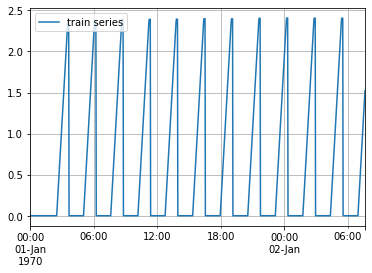

In [1435]:
entry = next(iter(train_data))
train_series = to_pandas(entry)
train_series.plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.savefig("fig1.pdf",bbox_inches="tight")
plt.show()

In [1436]:
test_data = ListDataset(
    [{"start": df_input.index[0], "target": df_input.Discharge_Capacity[:]}],
    freq = "2min"
)

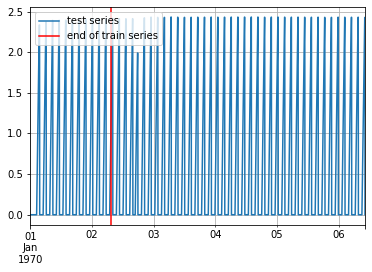

In [1437]:
entry = next(iter(test_data))
test_series = to_pandas(entry)
test_series.plot()
plt.axvline(train_series.index[-1], color='r') # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.savefig("fig2.pdf",bbox_inches="tight")
plt.show()

In [1438]:
print(f"Length of forecasting window in test dataset:{len(test_series)-len(train_series)}")
print(f"Frequency of the time series:{freq}")

Length of forecasting window in test dataset:2961
Frequency of the time series:2min


In [1439]:
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.mx.trainer import Trainer

In [1440]:
estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=250,
    context_length=50,
    freq="2min",
    trainer=Trainer(ctx="cpu", 
                    epochs=5, 
                    learning_rate=1e-3, 
                    num_batches_per_epoch=100
                   )
)

In [1441]:
predictor = estimator.train(train_data)

100%|██████████| 100/100 [00:01<00:00, 86.46it/s, epoch=5/5, avg_epoch_loss=-.182]


In [1442]:
from gluonts.evaluation.backtest import make_evaluation_predictions

In [1443]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data,  # test dataset
    predictor=predictor,  # predictor
    num_samples=500,  # number of sample paths we want for evaluation 100
)

In [1444]:
forecasts = list(forecast_it)
tss = list(ts_it)

In [1445]:
# first entry of the time series list
ts_entry = tss[0]

In [1446]:
# first 5 values of the time series (convert from pandas to numpy)
np.array(ts_entry[:5]).reshape(-1,)

array([0., 0., 0., 0., 0.], dtype=float32)

In [1447]:
# first entry of dataset.test
dataset_test_entry = next(iter(test_data))

In [1448]:
# first 5 values
dataset_test_entry['target'][:5]

array([0., 0., 0., 0., 0.], dtype=float32)

In [1450]:
# first entry of the forecast list
forecast_entry = forecasts[0]

In [1451]:
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 500
Dimension of samples: (500, 250)
Start date of the forecast window: 1970-01-06 02:00:00
Frequency of the time series: 2min


In [1452]:
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

Mean of the future window:
 [ 1.53607535e+00  1.54247451e+00  1.59013796e+00  1.59462845e+00
  1.44889927e+00  1.54698181e+00  1.67590010e+00  1.47379208e+00
  1.03125918e+00  6.43856764e-01  9.10724521e-01  4.76775676e-01
  7.17468441e-01  2.18800694e-01  1.32423028e-01  1.52330287e-02
  1.70515001e-01 -2.11142488e-02 -1.06422342e-02 -6.86531737e-02
 -3.84281343e-03 -8.26475769e-03  1.38427196e-02 -6.82120305e-03
 -6.49498729e-03  1.33542707e-02  1.81543967e-03  7.79840862e-03
  1.80726557e-03  2.41162372e-03  1.59824686e-03  5.77633362e-03
  1.49461639e-03 -1.02471467e-03  9.54774965e-04 -7.81770051e-03
  3.57955229e-03  3.79479164e-03  6.31660596e-03  6.41160586e-04
  5.08703012e-03  1.99184334e-03 -4.34854394e-03 -2.88555189e-03
 -2.83059548e-03  4.39928938e-03 -1.14269713e-02 -9.08007205e-04
 -3.38004832e-03  1.29631651e-03  1.03549811e-03 -5.45626553e-03
  1.48026571e-02  7.74408167e-04 -6.88831229e-03 -3.94909969e-03
  2.71089915e-02  3.74220088e-02  9.77810025e-02  1.76328763e-

In [1453]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 500
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.ylim(0,3)
    plt.legend(legend, loc="upper left")
    plt.savefig("fig3.pdf",bbox_inches="tight")
    plt.show()

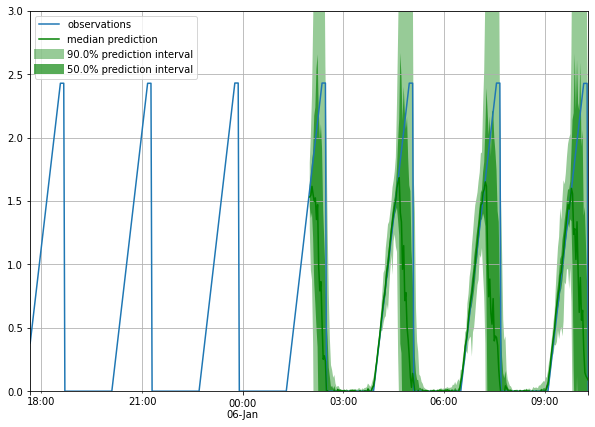

In [1454]:
plot_prob_forecasts(ts_entry, forecast_entry)

In [1455]:
from gluonts.evaluation import Evaluator


In [1456]:
evaluator = Evaluator(quantiles=[0.5,0.1,0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_data))

Running evaluation: 100%|██████████| 1/1 [00:00<00:00, 23.07it/s]


In [1457]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 0.5105601196289062,
    "abs_error": 77.1292724609375,
    "abs_target_sum": 173.8040771484375,
    "abs_target_mean": 0.69521630859375,
    "seasonal_error": 0.9881286205888605,
    "MASE": 0.31222361483659267,
    "MAPE": 1881619.2621359224,
    "sMAPE": 1.27024560546875,
    "MSIS": 3.1341184182373354,
    "QuantileLoss[0.5]": 77.12927051200677,
    "Coverage[0.5]": 0.536,
    "QuantileLoss[0.1]": 47.440081378561445,
    "Coverage[0.1]": 0.024,
    "QuantileLoss[0.9]": 24.714437349338546,
    "Coverage[0.9]": 0.964,
    "RMSE": 0.7145348974185279,
    "NRMSE": 1.0277878821108994,
    "ND": 0.44377136443735543,
    "wQuantileLoss[0.5]": 0.4437713532239779,
    "wQuantileLoss[0.1]": 0.2729514874271057,
    "wQuantileLoss[0.9]": 0.14219710926706952,
    "mean_absolute_QuantileLoss": 49.76126307996892,
    "mean_wQuantileLoss": 0.2863066499727177,
    "MAE_Coverage": 0.058666666666666666,
    "OWA": NaN
}


In [1458]:
item_metrics

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,MSIS,QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.9],Coverage[0.9]
0,NaN,0.51056,77.129272,173.804077,0.695216,0.988129,0.312224,1.881619e+06,1.270246,3.134118,77.129271,0.536,47.440081,0.024,24.714437,0.964


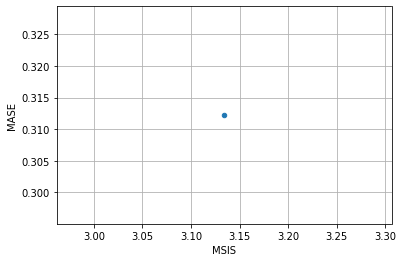

In [1459]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.savefig("fig4.pdf",bbox_inches="tight")
plt.show()

In [1460]:
# own forecast model

In [1461]:
class MyNetwork(gluon.HybridBlock):
    def __init__(self, prediction_length, num_cells, **kwargs):
        super().__init__(**kwargs)
        self.prediction_length = prediction_length
        self.num_cells = num_cells

        with self.name_scope():
            # Set up a 3 layer neural network that directly predicts the target values
            self.nn = mx.gluon.nn.HybridSequential()
            self.nn.add(mx.gluon.nn.Dense(units=820, activation='relu'))
            self.nn.add(mx.gluon.nn.Dense(units=820, activation='relu'))
            self.nn.add(mx.gluon.nn.Dense(units=self.prediction_length, activation='relu'))


class MyTrainNetwork(MyNetwork):
    def hybrid_forward(self, F, past_target, future_target):
        prediction = self.nn(past_target)
        # calculate L1 loss with the future_target to learn the median
        return (prediction - future_target).abs().mean(axis=-1)


class MyPredNetwork(MyTrainNetwork):
    # The prediction network only receives past_target and returns predictions
    def hybrid_forward(self, F, past_target):
        prediction = self.nn(past_target)
        return prediction.expand_dims(axis=1)

In [1462]:
def plot_prob_forecasts_2(ts_entry, forecast_entry):
    plot_length = 500
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.ylim(0,3)
    plt.legend(legend, loc="upper left")
    plt.savefig("fig5.pdf",bbox_inches="tight")
    plt.show()

In [1463]:
from functools import partial
from mxnet.gluon import HybridBlock
from gluonts.core.component import validated
from gluonts.dataset.loader import TrainDataLoader
from gluonts.model.predictor import Predictor
from gluonts.mx.batchify import as_in_context, batchify
from gluonts.mx.model.estimator import GluonEstimator
from gluonts.mx.model.predictor import RepresentableBlockPredictor
from gluonts.mx.trainer import Trainer
from gluonts.mx.util import copy_parameters, get_hybrid_forward_input_names
from gluonts.transform import (
    ExpectedNumInstanceSampler,
    Transformation,
    InstanceSplitter,
    TestSplitSampler,
    SelectFields,
    Chain
)

In [1464]:
class MyEstimator(GluonEstimator):
    @validated()
    def __init__(
        self,
        prediction_length: int,
        context_length: int,
        freq: str,
        num_cells: int,
        batch_size: int = 32,
        trainer: Trainer = Trainer()
    ) -> None:
        super().__init__(trainer=trainer, batch_size=batch_size)
        self.prediction_length = prediction_length
        self.context_length = context_length
        self.freq = freq
        self.num_cells = num_cells

    def create_transformation(self):
        return Chain([])

    def create_training_data_loader(self, dataset, **kwargs):
        instance_splitter = InstanceSplitter(
            target_field=FieldName.TARGET,
            is_pad_field=FieldName.IS_PAD,
            start_field=FieldName.START,
            forecast_start_field=FieldName.FORECAST_START,
            instance_sampler=ExpectedNumInstanceSampler(
                num_instances=1,
                min_future=self.prediction_length
            ),
            past_length=self.context_length,
            future_length=self.prediction_length,
        )
        input_names = get_hybrid_forward_input_names(MyTrainNetwork)
        return TrainDataLoader(
            dataset=dataset,
            transform=instance_splitter + SelectFields(input_names),
            batch_size=self.batch_size,
            stack_fn=partial(batchify, ctx=self.trainer.ctx, dtype=self.dtype),
            decode_fn=partial(as_in_context, ctx=self.trainer.ctx),
            **kwargs,
        )

    def create_training_network(self) -> MyTrainNetwork:
        return MyTrainNetwork(
            prediction_length=self.prediction_length,
            num_cells = self.num_cells
        )

    def create_predictor(
        self, transformation: Transformation, trained_network: HybridBlock
    ) -> Predictor:
        prediction_splitter = InstanceSplitter(
            target_field=FieldName.TARGET,
            is_pad_field=FieldName.IS_PAD,
            start_field=FieldName.START,
            forecast_start_field=FieldName.FORECAST_START,
            instance_sampler=TestSplitSampler(),
            past_length=self.context_length,
            future_length=self.prediction_length,
        )

        prediction_network = MyPredNetwork(
            prediction_length=self.prediction_length,
            num_cells=self.num_cells
        )

        copy_parameters(trained_network, prediction_network)

        return RepresentableBlockPredictor(
            input_transform=transformation + prediction_splitter,
            prediction_net=prediction_network,
            batch_size=self.trainer.batch_size,
            freq=self.freq,
            prediction_length=self.prediction_length,
            ctx=self.trainer.ctx,
        )

In [1465]:

# define the parameters of the dataset
custom_ds_metadata = {
    'num_series': 1,
    'num_steps': 1901,
    'prediction_length': 100,
    'freq': '2min',
    'start': [
        pd.Timestamp("01-01-2019", freq='2min')
        for _ in range(100)
    ]
}

In [1487]:
estimator = MyEstimator(
    prediction_length=250,     #custom_ds_metadata['prediction_length'],
    context_length = custom_ds_metadata['prediction_length'],
    freq=custom_ds_metadata['freq'],
    num_cells=40, #50
    trainer=Trainer(
        ctx="cpu",
        epochs=5,
        learning_rate=1e-2, #-2
        hybridize=False,
        num_batches_per_epoch=2000
    )
)

In [1488]:
from gluonts.dataset.field_names import FieldName
[f"FieldName.{k} = '{v}'" for k, v in FieldName.__dict__.items() if not k.startswith('_')]

["FieldName.ITEM_ID = 'item_id'",
 "FieldName.START = 'start'",
 "FieldName.TARGET = 'target'",
 "FieldName.FEAT_STATIC_CAT = 'feat_static_cat'",
 "FieldName.FEAT_STATIC_REAL = 'feat_static_real'",
 "FieldName.FEAT_DYNAMIC_CAT = 'feat_dynamic_cat'",
 "FieldName.FEAT_DYNAMIC_REAL = 'feat_dynamic_real'",
 "FieldName.PAST_FEAT_DYNAMIC_REAL = 'past_feat_dynamic_real'",
 "FieldName.FEAT_DYNAMIC_REAL_LEGACY = 'dynamic_feat'",
 "FieldName.FEAT_DYNAMIC = 'feat_dynamic'",
 "FieldName.PAST_FEAT_DYNAMIC = 'past_feat_dynamic'",
 "FieldName.FEAT_TIME = 'time_feat'",
 "FieldName.FEAT_CONST = 'feat_dynamic_const'",
 "FieldName.FEAT_AGE = 'feat_dynamic_age'",
 "FieldName.OBSERVED_VALUES = 'observed_values'",
 "FieldName.IS_PAD = 'is_pad'",
 "FieldName.FORECAST_START = 'forecast_start'",
 "FieldName.TARGET_DIM_INDICATOR = 'target_dimension_indicator'"]

In [1489]:
predictor = estimator.train(train_data)

100%|██████████| 2000/2000 [01:37<00:00, 20.41it/s, epoch=5/5, avg_epoch_loss=0.198]


In [1490]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [1491]:
forecasts = list(forecast_it)
tss = list(ts_it)

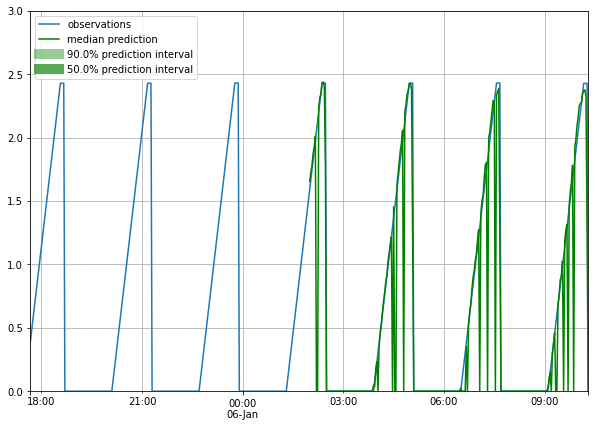

In [1492]:
plot_prob_forecasts_2(tss[0], forecasts[0])

In [1493]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_data))

Running evaluation: 100%|██████████| 1/1 [00:00<00:00, 29.34it/s]


In [1494]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 0.16761434936523437,
    "abs_error": 31.329835891723633,
    "abs_target_sum": 173.8040771484375,
    "abs_target_mean": 0.69521630859375,
    "seasonal_error": 0.9881286205888605,
    "MASE": 0.12682493043487833,
    "MAPE": 234732.1941747573,
    "sMAPE": 1.0723118436509285,
    "MSIS": 5.07299690855297,
    "QuantileLoss[0.1]": 11.579370782880032,
    "Coverage[0.1]": 0.288,
    "QuantileLoss[0.5]": 31.32983600153547,
    "Coverage[0.5]": 0.288,
    "QuantileLoss[0.9]": 51.08030122019092,
    "Coverage[0.9]": 0.288,
    "RMSE": 0.409407314743196,
    "NRMSE": 0.5888919889858818,
    "ND": 0.18025949911961134,
    "wQuantileLoss[0.1]": 0.06662312514677467,
    "wQuantileLoss[0.5]": 0.18025949975142527,
    "wQuantileLoss[0.9]": 0.29389587435607595,
    "mean_absolute_QuantileLoss": 31.329836001535472,
    "mean_wQuantileLoss": 0.1802594997514253,
    "MAE_Coverage": 0.3373333333333333,
    "OWA": NaN
}


In [1495]:
item_metrics.head(10)

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,NaN,0.167614,31.329836,173.804077,0.695216,0.988129,0.126825,234732.194175,1.072312,5.072997,11.579371,0.288,31.329836,0.288,51.080301,0.288


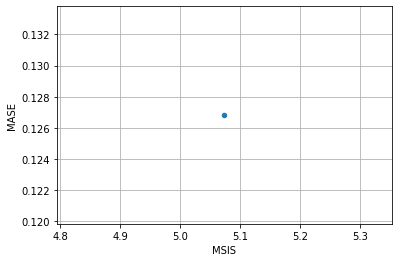

In [1496]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.savefig("fig6.pdf",bbox_inches="tight")
plt.show()